# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей применяйте метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.

В нашем распоряжении следущие признаки:

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

## Подготовка данных

### Загрузка данных.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import  make_pipeline
from sklearn.ensemble import RandomForestRegressor
!pip install optuna
import optuna
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Загрузим данные
data=pd.read_csv('/datasets/autos.csv')
print(data.info())
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [3]:
# Приведем название столбцов к нижнему регистру.
data.rename(columns=lambda x:x.lower(),inplace = True )
data.head(1)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57


### Работа с дубликатами и пропусками

In [4]:
#Проверим на количество дубликатов
print(data.duplicated().sum())

4


In [5]:
#Удалим
data.drop_duplicates()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Займемся пропусками. В числовых фичах пропусков нет,а вот в категориальных есть почти во всех. Проверим поочередно.

In [6]:
data_new=data
#Тип кузова
print(data_new['vehicletype'].unique())
print('количество пропущенных значений',data_new['vehicletype'].isna().sum())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
количество пропущенных значений 37490


In [7]:
# Поставим заглушку "other"
data_new['vehicletype']=data_new['vehicletype'].fillna('other')

In [8]:
#Коробка передач
print(data_new['gearbox'].unique())
print('количество пропущенных значений',data_new['gearbox'].isna().sum())

['manual' 'auto' nan]
количество пропущенных значений 19833


In [9]:
data_new['gearbox']=data_new['gearbox'].fillna('unknown')

In [10]:
# Модель
print(data_new['model'].unique())
print('количество пропущенных значений',data_new['model'].isna().sum())

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

In [11]:
# Поставим заглушку "other"
data_new['model']=data_new['model'].fillna('other')

In [12]:
#был ли восстановлен(ремонт)
print(data_new['repaired'].unique())
print('количество пропущенных значений',data_new['repaired'].isna().sum())

[nan 'yes' 'no']
количество пропущенных значений 71154


In [13]:
# Поставим заглушку "other"
data_new['repaired']=data_new['repaired'].fillna('other')

In [14]:
# Тип двигателя
print(data_new['fueltype'].unique())
print('количество пропущенных значений',data_new['fueltype'].isna().sum())

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
количество пропущенных значений 32895


In [15]:
# Поставим заглушку "other"
data_new['fueltype']=data_new['fueltype'].fillna('other')

In [16]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        354369 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            354369 non-null  object
 5   power              354369 non-null  int64 
 6   model              354369 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           354369 non-null  object
 10  brand              354369 non-null  object
 11  repaired           354369 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

*** Все пропуски заполнены. ***

### Обработка аномалий.

*** Проанализируем числовые признаки.***

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


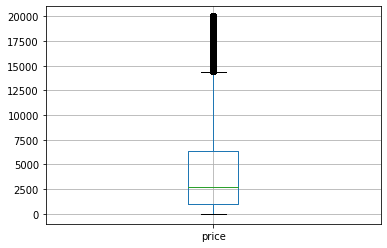

In [17]:
# Для начала целевое значение.
print(data_new['price'].describe())
print(data_new.boxplot(column=['price'], grid=True))


***Здесь критических выбросов нет,т.к все данные лежат в пределах 20000(возможно премиальные или дорогостоящие ретрокары).Здесь достаточно удалить нулевые цены.***

In [18]:
#Подрежем нулевые цены.
data_new=data_new.query('price !=0')
data_new.shape

(343597, 16)

In [19]:
# Год выпуска.
print(sorted(data_new['registrationyear'].unique()))


[1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7800, 8000, 8200, 8500, 8888, 9000, 9450, 9999]


***Год выпуска одна из важнейших характеристик прямо влияющих на стоимость автомобилей. Здесь,как мы видим,достаточно много "кривых" значений. Неизвестно,что стало причиной. ***

***В качестве верхней границы возьмем дату последней загруженной анкеты(столбец DateCrawled)***

In [20]:
data_new['datecrawled'].max()

'2016-04-07 14:36:58'

***Поскольку последняя скачанная анкета для этой базы датирована  2016г,то все регистрации после этой даты по логике задачи не должны были попасть в скаченную базу.***

**С верхней границей определились. Теперь необходимо определить нижнюю. Воспользуемся сводной таблицей и посмотрим количество авто по году регистрации.**

<AxesSubplot:xlabel='registrationyear'>

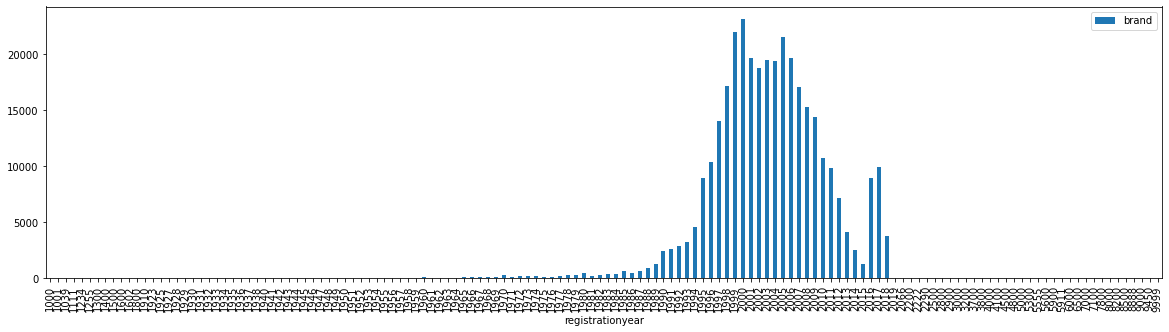

In [21]:
pivot=pd.pivot_table(data_new,index='registrationyear',values='brand',aggfunc='count')
pivot.plot.bar(figsize = (20,5))

**Здесь к нормальному распределению можно отнести авто с годом регистрации 1980 и старше.**

In [22]:
#Подрежем по году регистрации.
data_new=data_new.query('1980 <= registrationyear <= 2016 ')
data_new.shape

(326652, 16)

count    326652.000000
mean        112.221186
std         183.348304
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


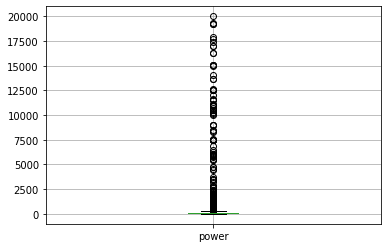

In [23]:
# Мощность двигателя.
print(data_new['power'].describe())
print(data_new.boxplot(column=['power'], grid=True))


***Как мы видим очень много выбросов по значению мощности двигателя. Трудно выявить конкретную причину. Возможно это ошибка размерности при заполнении данных в анкете,возможно что-то с выгрузкой. Предлагаю ограничить мощность двигателя по наименьшим и наибольшим значениям серийных автомобилей (15 л.с наименьшее 1600 л.с наибольшее)***


In [24]:
data_new=data_new.query('15 <= power <= 1600 ')
data_new.shape

(294274, 16)

count    294274.000000
mean     128603.359454
std       36478.515553
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


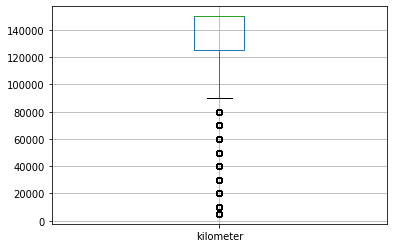

In [25]:
# Пробег
print(data_new['kilometer'].describe())
print(data_new.boxplot(column=['kilometer'], grid=True))

***С километражом в целом порядок,нижний хвост скорее всего относится к свежим моделям.***

### Удаление неиформативных признаков

Удалим признаки,которые однозначно не несут смысловой нагрузки на цену автомобиля. К таким я бы отнес:

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя).

LastSeen — дата последней активности пользователя

datecrawled - дата скачивания анкеты 

datecreated - дата создания анкеты

registrationmonth - месяц регистрации


In [26]:
data_new=data_new.drop(['lastseen','postalcode','numberofpictures','registrationmonth','datecrawled','datecreated'],axis=1)

data_new.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


### Проверка корреляции и общие выводы после предобработки.

In [27]:
print(data_new.corr())
print(data_new.info())
print(data_new.shape)

                     price  registrationyear     power  kilometer
price             1.000000          0.569541  0.461375  -0.388203
registrationyear  0.569541          1.000000  0.122110  -0.366107
power             0.461375          0.122110  1.000000   0.089112
kilometer        -0.388203         -0.366107  0.089112   1.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 294274 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             294274 non-null  int64 
 1   vehicletype       294274 non-null  object
 2   registrationyear  294274 non-null  int64 
 3   gearbox           294274 non-null  object
 4   power             294274 non-null  int64 
 5   model             294274 non-null  object
 6   kilometer         294274 non-null  int64 
 7   fueltype          294274 non-null  object
 8   brand             294274 non-null  object
 9   repaired          294274 non-null  ob

Наюлюдается достаточно сильная положительная связь между таргетом и мощностью двигателя, а также таргетом с годом регистрации.

#### Выводы

После загрузки данных была сделана следущая предобработка.

-Удалены дубликаты.

-Заполнены пропуски.

-Удалены аномальные данные и выбросы из данных. Наш исходник потерял около 17% данных,но они стали намного чище в информационном плане и остается достаточно большим (290000+) для построения эффективной модели прогнозирования.

-Удалены неиформативные для ценообразования признаки(дата скачивания и создания анкет ,количество картинок и т.д.)

-Обнаружена корреляционная зависимость между таргетом и 2мя признаками.

## Обучение моделей

Для моделей обучения выберем модель линейной регрессии,модель Random Forrest,CatBoost,LGB. Для каждой модели необходимо будет по разному готовить данные,поэтому каждую модель будем рассматривать отдельно.

### Модель линейной регрессии.

*** Поскольку в нашей модели много категориальных признаков ,необходимо преобразовать их с помощью OHE (остальные не подойдут)***

In [28]:
data_lr = data_new
#выделяю признаки и целевой признак:
features_lr = data_lr.drop('price', axis=1)
target_lr = data_lr.price

In [29]:
# Разбиваем на выборки
features_train, features_test, target_train, target_test = train_test_split(features_lr,
                                                                            target_lr, 
                                                                            test_size=.25,
                                                                            random_state=12345)

In [30]:
# Кодируем фичи в трейне с помощью OHE
features_train_lr= pd.get_dummies(features_train, drop_first=True)
features_test_lr= pd.get_dummies(features_test, drop_first=True)

In [31]:
# Также необходим стандартизировать числовые признаки
scaler = StandardScaler()
quanti_columns = ['registrationyear', 'power', 'kilometer']
scaler.fit(features_train_lr[quanti_columns])
features_train_lr[quanti_columns] = scaler.transform(features_train_lr[quanti_columns])
features_test_lr[quanti_columns] = scaler.transform(features_test_lr[quanti_columns])

In [32]:
#Запустим таймер
st=time.time()
# Запускаем модель
model_lr = LinearRegression()
model_lr.fit(features_train_lr, target_train)
et=time.time()
print('Время обучения',round(et-st),'секунд')

Время обучения 84 секунд


In [33]:
st=time.time()
target_predict = model_lr.predict(features_test_lr)
et=time.time()
print('Время время предсказния',round(et-st),'секунд')

Время время предсказния 0 секунд


In [34]:
rmse_lr = mse(target_test,target_predict) ** 0.5
print("Метрика на модели линейной регресии",rmse_lr)

Метрика на модели линейной регресии 2754.705801765118


*** Модель довольно быстро обучилась, но метрика качества неудовлетворительная. ***

### Модель случайного леса.

In [35]:
data_rfr = data_new
#выделяю признаки и целевой признак:
features_rfr = data_rfr.drop('price', axis=1)
target_rfr = data_rfr.price

In [36]:
features_train_rfr, features_test_rfr, target_train_rfr, target_test_rfr = train_test_split(features_rfr,
                                                                            target_rfr, 
                                                                            test_size=.25,
                                                                            random_state=12345)

*** Здесь нам также предстоит убрать категориальные признаки,однако метод OHE здесь не подойдет,т.к. количество признаков станет 300+ и работа модели сильно усложниться. Воспользуемся Ordinal encoder. ***

In [37]:
#
ct = ColumnTransformer(transformers=[('encoder',OrdinalEncoder(),['vehicletype','gearbox','model','fueltype','brand','repaired'])],remainder='passthrough')
features_train_rfr_oe=ct.fit_transform(features_train_rfr)
features_test_rfr_oe=ct.fit_transform(features_test_rfr)


In [38]:
# Данные готовы.Можно запускать модель.

rfr=make_pipeline(StandardScaler(), RandomForestRegressor())
parametrs={'randomforestregressor__n_estimators':[1,100],
            'randomforestregressor__max_depth':[1,5],
            'randomforestregressor__random_state':[12345]}
price_rfr = RandomizedSearchCV(rfr,parametrs, cv=5,scoring ='neg_root_mean_squared_error')

In [39]:
st=time.time()
price_rfr.fit(features_train_rfr_oe,target_train_rfr)
et=time.time()
print('Время обучения',round(et-st),'секунд')

Время обучения 133 секунд


In [40]:
st=time.time()
test_pred=price_rfr.predict(features_test_rfr_oe)
et=time.time()
print('Время предсказания',round(et-st),'секунд')
rmse=mse(target_test_rfr,test_pred)**0.5
print("Метрика на модели линейной регресии",rmse)

Время предсказания 0 секунд
Метрика на модели линейной регресии 2334.7841263285777


**Здесь метрика улучшила значение и проходит по условиям задачи, и заметно увеличилось время обучения**

### Модель CatBoost

**Одно из главных преимуществ этой модели в том,что никакой предобработки данных признаков не требуется.**

In [41]:
data_cat = data_new
#выделяю признаки и целевой признак:
features_cat = data_cat.drop('price', axis=1)
target_cat = data_cat.price

In [42]:
# Разбиваем на выборки
features_train, features_test, target_train, target_test = train_test_split(features_cat,
                                                                            target_cat, 
                                                                            test_size=.25,
                                                                            random_state=12345)

In [43]:
#Выделим категориальные признаки
cat_list=['vehicletype','gearbox','model','brand','repaired','fueltype']

In [44]:
#Для перебора гиперпараметров в градиентных функциях воспользуемся Optuna
#определим функцию оптимизации
def objective(trial):
    params = {'iterations':30,
             'depth':trial.suggest_int('depth',2,5),
             'cat_features':cat_list}
    model=CatBoostRegressor(**params,verbose=False)
    model.fit(features_train,target_train)
    pred_train=model.predict(features_train)
    rmse=mse(target_train,pred_train)**0.5
    return rmse

In [45]:
st=time.time()
#Создадим объект study и запустим оптимизацию
study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=30,n_jobs=-1)
et=time.time()
print('Время обучения',round(et-st),'секунд')

[I 2023-06-29 19:52:29,168] A new study created in memory with name: no-name-d3fdf88c-202f-4d7d-8025-10974b8e512e
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2023-06-29 19:52:56,073] Trial 2 finished with value: 1991.8923181918199 and parameters: {'depth': 2}. Best is trial 2 with value: 1991.8923181918199.
[I 2023-06-29 19:53:03,188] Trial 4 finished with val

Время обучения 131 секунд


In [46]:
##Вытащим лучшие гиперпараметры и обучим модель 
best_params=study.best_params
print(best_params)


{'depth': 5}


In [47]:
st=time.time()
params = {'iterations':30,
             'depth':5,
             'cat_features':cat_list}
model=CatBoostRegressor(**params,verbose=False)
model.fit(features_train,target_train)
pred_test=model.predict(features_test)
et=time.time()
print('Время предсказания',round(et-st),'секунд')
rmse=mse(target_test,pred_test)**0.5
print('Метрика на лучших параметрах',rmse)

Время предсказания 4 секунд
Метрика на лучших параметрах 1739.3568299433452


*** Достаточно большое время получения прогноза,но показатель метрики значительно улучшился по сравнению с предыдущими моделями.***

###  Модель LightGBM

*** В данной модели также не требуется преобразование категориальных признаков. Параметры также подберем через Optune ***

In [48]:
data_gbm = data_new
#выделяю признаки и целевой признак:
features_gbm = data_gbm.drop('price', axis=1)
target_gbm = data_gbm.price
cat_list=['vehicletype','gearbox','model','brand','repaired','fueltype']
#Переведем категориальные данные к типу category,которые необходимы по условию модели lgb.
features_gbm[cat_list] = features_gbm[cat_list].astype('category')


In [49]:
# Разбиваем на выборки
#features_train, features_test, target_train, target_test = train_test_split(features_gbm,
#                                                                            target_gbm, 
#                                                                            test_size=.25,
#                                                                            random_state=12345)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(features_gbm,target_gbm, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(176564, 9)
(58855, 9)
(58855, 9)


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Данные поделены верно, пропорции выбраны адекватные 👍
</div>

In [51]:
def trial(trial):
    # Определение гиперпараметров для оптимизации
        params = {
        'objective': 'regression',
        'metric': 'mse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        #'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        #'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50)}
        # Создание модели LightGBM
        model = lgb.LGBMRegressor(**params)
        # Обучение модели
        model.fit(X_train,y_train, eval_set=[(X_val,y_val)],categorical_feature=cat_list)
        pred_val = model.predict(X_val)
        rmse=mse(y_val,pred_val)**0.5
        return rmse


In [52]:
st=time.time()
## Обучение модели с определенными гиперпараметрами
study = optuna.create_study(direction='minimize')
study.optimize(trial, n_trials=30,n_jobs=-1)
et=time.time()
print('Время обучения и предсказания',round(et-st),'секунд')

[I 2023-06-29 19:54:44,577] A new study created in memory with name: no-name-1254fe5b-1232-4ebf-aaad-5e108e42f25b


[1]	valid_0's l2: 1.80782e+07
[1]	valid_0's l2: 1.78004e+07
[1]	valid_0's l2: 1.78089e+07
[2]	valid_0's l2: 1.57299e+07
[1]	valid_0's l2: 1.78665e+07
[1]	valid_0's l2: 1.78066e+07
[1]	valid_0's l2: 1.80197e+07
[3]	valid_0's l2: 1.37573e+07
[1]	valid_0's l2: 1.78856e+07
[4]	valid_0's l2: 1.21276e+07
[1]	valid_0's l2: 1.79184e+07
[2]	valid_0's l2: 1.56201e+07
[5]	valid_0's l2: 1.07311e+07
[2]	valid_0's l2: 1.53458e+07
[2]	valid_0's l2: 1.52011e+07
[2]	valid_0's l2: 1.53132e+07
[2]	valid_0's l2: 1.54215e+07
[6]	valid_0's l2: 9.57217e+06
[2]	valid_0's l2: 1.52047e+07
[2]	valid_0's l2: 1.51916e+07
[3]	valid_0's l2: 1.36043e+07
[7]	valid_0's l2: 8.59921e+06
[3]	valid_0's l2: 1.32656e+07
[8]	valid_0's l2: 7.78964e+06
[4]	valid_0's l2: 1.19799e+07
[3]	valid_0's l2: 1.33688e+07
[3]	valid_0's l2: 1.30598e+07
[3]	valid_0's l2: 1.32121e+07
[9]	valid_0's l2: 7.10711e+06
[3]	valid_0's l2: 1.30494e+07
[3]	valid_0's l2: 1.30678e+07
[4]	valid_0's l2: 1.15565e+07
[5]	valid_0's l2: 1.05531e+07
[10]	valid

[I 2023-06-29 19:55:18,155] Trial 0 finished with value: 1581.2492938517855 and parameters: {'num_leaves': 21, 'min_child_samples': 18}. Best is trial 0 with value: 1581.2492938517855.


[73]	valid_0's l2: 2.53509e+06
[49]	valid_0's l2: 2.5309e+06
[74]	valid_0's l2: 2.53244e+06
[41]	valid_0's l2: 2.51762e+06
[53]	valid_0's l2: 2.45095e+06
[41]	valid_0's l2: 2.43379e+06
[75]	valid_0's l2: 2.52811e+06
[33]	valid_0's l2: 2.5664e+06
[36]	valid_0's l2: 2.49512e+06
[50]	valid_0's l2: 2.52363e+06
[76]	valid_0's l2: 2.52505e+06
[54]	valid_0's l2: 2.44504e+06
[42]	valid_0's l2: 2.50659e+06
[77]	valid_0's l2: 2.5228e+06
[42]	valid_0's l2: 2.42299e+06
[78]	valid_0's l2: 2.52043e+06
[34]	valid_0's l2: 2.54332e+06
[51]	valid_0's l2: 2.51644e+06
[37]	valid_0's l2: 2.47884e+06
[52]	valid_0's l2: 2.51063e+06
[79]	valid_0's l2: 2.51705e+06
[55]	valid_0's l2: 2.4398e+06
[43]	valid_0's l2: 2.49767e+06
[53]	valid_0's l2: 2.50348e+06
[35]	valid_0's l2: 2.52755e+06
[1]	valid_0's l2: 1.79121e+07
[43]	valid_0's l2: 2.41512e+06
[80]	valid_0's l2: 2.51351e+06
[38]	valid_0's l2: 2.46519e+06
[2]	valid_0's l2: 1.54031e+07
[81]	valid_0's l2: 2.51148e+06
[56]	valid_0's l2: 2.43266e+06
[44]	valid_0's

[I 2023-06-29 19:55:27,563] Trial 6 finished with value: 1572.9454963613293 and parameters: {'num_leaves': 26, 'min_child_samples': 29}. Best is trial 6 with value: 1572.9454963613293.


[67]	valid_0's l2: 2.43994e+06
[47]	valid_0's l2: 2.38221e+06
[43]	valid_0's l2: 2.42927e+06
[68]	valid_0's l2: 2.43627e+06
[16]	valid_0's l2: 3.98945e+06
[71]	valid_0's l2: 2.38613e+06
[54]	valid_0's l2: 2.42141e+06
[17]	valid_0's l2: 3.81141e+06
[69]	valid_0's l2: 2.43417e+06
[44]	valid_0's l2: 2.42275e+06
[18]	valid_0's l2: 3.65458e+06
[48]	valid_0's l2: 2.37598e+06
[52]	valid_0's l2: 2.36375e+06
[55]	valid_0's l2: 2.41681e+06
[72]	valid_0's l2: 2.38389e+06
[19]	valid_0's l2: 3.52209e+06
[70]	valid_0's l2: 2.43048e+06
[49]	valid_0's l2: 2.36877e+06
[73]	valid_0's l2: 2.38181e+06
[56]	valid_0's l2: 2.41211e+06
[53]	valid_0's l2: 2.3587e+06
[45]	valid_0's l2: 2.41532e+06
[74]	valid_0's l2: 2.37963e+06
[20]	valid_0's l2: 3.40762e+06
[1]	valid_0's l2: 1.79546e+07
[50]	valid_0's l2: 2.3645e+06
[57]	valid_0's l2: 2.40837e+06
[75]	valid_0's l2: 2.37754e+06
[71]	valid_0's l2: 2.42764e+06
[21]	valid_0's l2: 3.30792e+06
[54]	valid_0's l2: 2.35559e+06
[2]	valid_0's l2: 1.54858e+07
[76]	valid_0

[I 2023-06-29 19:55:40,693] Trial 5 finished with value: 1529.16827562683 and parameters: {'num_leaves': 52, 'min_child_samples': 28}. Best is trial 5 with value: 1529.16827562683.


[67]	valid_0's l2: 2.31469e+06[43]	valid_0's l2: 2.56907e+06

[73]	valid_0's l2: 2.36194e+06
[63]	valid_0's l2: 2.3154e+06
[57]	valid_0's l2: 2.353e+06
[97]	valid_0's l2: 2.38662e+06
[74]	valid_0's l2: 2.35889e+06
[30]	valid_0's l2: 2.89253e+06
[44]	valid_0's l2: 2.55855e+06
[98]	valid_0's l2: 2.38591e+06
[58]	valid_0's l2: 2.34981e+06
[68]	valid_0's l2: 2.31291e+06
[31]	valid_0's l2: 2.86234e+06
[64]	valid_0's l2: 2.31283e+06
[75]	valid_0's l2: 2.35689e+06
[32]	valid_0's l2: 2.83359e+06
[76]	valid_0's l2: 2.35489e+06
[99]	valid_0's l2: 2.38462e+06
[45]	valid_0's l2: 2.54929e+06
[100]	valid_0's l2: 2.38427e+06
[33]	valid_0's l2: 2.81074e+06
[69]	valid_0's l2: 2.31078e+06
[65]	valid_0's l2: 2.30967e+06
[34]	valid_0's l2: 2.78807e+06
[77]	valid_0's l2: 2.3533e+06
[46]	valid_0's l2: 2.53508e+06
[59]	valid_0's l2: 2.34538e+06
[35]	valid_0's l2: 2.77029e+06
[47]	valid_0's l2: 2.52799e+06
[36]	valid_0's l2: 2.74969e+06
[1]	valid_0's l2: 1.7839e+07
[70]	valid_0's l2: 2.30869e+06
[60]	valid_0'

[I 2023-06-29 19:55:44,903] Trial 7 finished with value: 1544.1083263803148 and parameters: {'num_leaves': 41, 'min_child_samples': 3}. Best is trial 5 with value: 1529.16827562683.


[39]	valid_0's l2: 2.69987e+06
[50]	valid_0's l2: 2.50557e+06
[67]	valid_0's l2: 2.3063e+06
[81]	valid_0's l2: 2.34737e+06
[4]	valid_0's l2: 1.14087e+07
[51]	valid_0's l2: 2.49697e+06
[62]	valid_0's l2: 2.33822e+06
[82]	valid_0's l2: 2.34546e+06
[73]	valid_0's l2: 2.30505e+06
[40]	valid_0's l2: 2.68617e+06
[41]	valid_0's l2: 2.67334e+06
[68]	valid_0's l2: 2.30413e+06
[5]	valid_0's l2: 9.99023e+06
[83]	valid_0's l2: 2.34367e+06
[74]	valid_0's l2: 2.30327e+06
[52]	valid_0's l2: 2.49223e+06
[42]	valid_0's l2: 2.66137e+06
[53]	valid_0's l2: 2.48774e+06
[63]	valid_0's l2: 2.33645e+06
[69]	valid_0's l2: 2.30212e+06
[84]	valid_0's l2: 2.34245e+06
[43]	valid_0's l2: 2.64946e+06
[54]	valid_0's l2: 2.48379e+06
[6]	valid_0's l2: 8.79115e+06
[75]	valid_0's l2: 2.30203e+06
[44]	valid_0's l2: 2.6388e+06
[55]	valid_0's l2: 2.47688e+06
[85]	valid_0's l2: 2.33974e+06
[70]	valid_0's l2: 2.30046e+06
[76]	valid_0's l2: 2.29983e+06
[64]	valid_0's l2: 2.33384e+06
[56]	valid_0's l2: 2.47152e+06
[71]	valid_0'

[I 2023-06-29 19:55:56,403] Trial 2 finished with value: 1522.6649112752982 and parameters: {'num_leaves': 59, 'min_child_samples': 20}. Best is trial 2 with value: 1522.6649112752982.


[74]	valid_0's l2: 2.41052e+06
[25]	valid_0's l2: 3.12686e+06
[18]	valid_0's l2: 3.46232e+06
[68]	valid_0's l2: 2.49362e+06
[69]	valid_0's l2: 2.49058e+06
[26]	valid_0's l2: 3.06855e+06
[76]	valid_0's l2: 2.3104e+06
[70]	valid_0's l2: 2.48835e+06
[75]	valid_0's l2: 2.40872e+06
[90]	valid_0's l2: 2.27754e+06
[83]	valid_0's l2: 2.27805e+06
[76]	valid_0's l2: 2.40773e+06
[71]	valid_0's l2: 2.48517e+06
[27]	valid_0's l2: 3.02039e+06
[77]	valid_0's l2: 2.31016e+06
[77]	valid_0's l2: 2.4064e+06
[72]	valid_0's l2: 2.48308e+06
[19]	valid_0's l2: 3.34119e+06
[91]	valid_0's l2: 2.27693e+06
[78]	valid_0's l2: 2.40328e+06
[73]	valid_0's l2: 2.48075e+06
[28]	valid_0's l2: 2.97335e+06
[84]	valid_0's l2: 2.27625e+06
[78]	valid_0's l2: 2.30808e+06
[29]	valid_0's l2: 2.93119e+06
[79]	valid_0's l2: 2.40061e+06
[85]	valid_0's l2: 2.27492e+06
[74]	valid_0's l2: 2.47955e+06
[92]	valid_0's l2: 2.27586e+06
[79]	valid_0's l2: 2.30629e+06
[75]	valid_0's l2: 2.47541e+06
[30]	valid_0's l2: 2.89618e+06
[86]	valid

[I 2023-06-29 19:56:08,803] Trial 1 finished with value: 1504.056416857472 and parameters: {'num_leaves': 90, 'min_child_samples': 23}. Best is trial 1 with value: 1504.056416857472.


[55]	valid_0's l2: 2.53885e+06
[11]	valid_0's l2: 5.11208e+06
[98]	valid_0's l2: 2.25813e+06
[33]	valid_0's l2: 2.6134e+06
[92]	valid_0's l2: 2.28913e+06
[34]	valid_0's l2: 2.59443e+06
[56]	valid_0's l2: 2.53443e+06
[93]	valid_0's l2: 2.28886e+06


[I 2023-06-29 19:56:10,067] Trial 9 finished with value: 1553.8938275318555 and parameters: {'num_leaves': 34, 'min_child_samples': 44}. Best is trial 1 with value: 1504.056416857472.


[99]	valid_0's l2: 2.25615e+06
[57]	valid_0's l2: 2.52867e+06
[35]	valid_0's l2: 2.57205e+06
[58]	valid_0's l2: 2.5228e+06
[94]	valid_0's l2: 2.28727e+06


[I 2023-06-29 19:56:10,598] Trial 8 finished with value: 1537.652646705579 and parameters: {'num_leaves': 44, 'min_child_samples': 24}. Best is trial 1 with value: 1504.056416857472.


[12]	valid_0's l2: 4.71688e+06
[100]	valid_0's l2: 2.25554e+06
[36]	valid_0's l2: 2.55495e+06
[59]	valid_0's l2: 2.51565e+06
[1]	valid_0's l2: 1.83554e+07
[37]	valid_0's l2: 2.5411e+06
[2]	valid_0's l2: 1.6204e+07
[95]	valid_0's l2: 2.28655e+06
[13]	valid_0's l2: 4.38596e+06
[60]	valid_0's l2: 2.51181e+06
[3]	valid_0's l2: 1.43137e+07
[4]	valid_0's l2: 1.27822e+07
[5]	valid_0's l2: 1.14527e+07
[61]	valid_0's l2: 2.50866e+06
[38]	valid_0's l2: 2.52723e+06
[62]	valid_0's l2: 2.50379e+06
[6]	valid_0's l2: 1.0333e+07
[14]	valid_0's l2: 4.10308e+06
[63]	valid_0's l2: 2.49911e+06
[7]	valid_0's l2: 9.38777e+06
[96]	valid_0's l2: 2.28328e+06
[64]	valid_0's l2: 2.49522e+06
[8]	valid_0's l2: 8.57736e+06
[39]	valid_0's l2: 2.51637e+06
[1]	valid_0's l2: 1.80782e+07
[9]	valid_0's l2: 7.88438e+06
[65]	valid_0's l2: 2.4918e+06
[2]	valid_0's l2: 1.57299e+07
[66]	valid_0's l2: 2.48691e+06
[10]	valid_0's l2: 7.30752e+06


[I 2023-06-29 19:56:14,234] Trial 3 finished with value: 1501.8447203415867 and parameters: {'num_leaves': 93, 'min_child_samples': 33}. Best is trial 3 with value: 1501.8447203415867.


[15]	valid_0's l2: 3.86822e+06
[67]	valid_0's l2: 2.48331e+06
[3]	valid_0's l2: 1.37573e+07
[40]	valid_0's l2: 2.5033e+06
[11]	valid_0's l2: 6.81124e+06
[68]	valid_0's l2: 2.48104e+06
[4]	valid_0's l2: 1.21276e+07
[97]	valid_0's l2: 2.28267e+06
[1]	valid_0's l2: 1.79284e+07
[69]	valid_0's l2: 2.47656e+06
[12]	valid_0's l2: 6.37018e+06
[41]	valid_0's l2: 2.49329e+06
[70]	valid_0's l2: 2.47306e+06
[5]	valid_0's l2: 1.07311e+07
[71]	valid_0's l2: 2.47015e+06
[13]	valid_0's l2: 6.00705e+06
[14]	valid_0's l2: 5.66713e+06
[72]	valid_0's l2: 2.46722e+06
[2]	valid_0's l2: 1.5457e+07
[15]	valid_0's l2: 5.37804e+06
[98]	valid_0's l2: 2.28171e+06
[16]	valid_0's l2: 3.67295e+06
[6]	valid_0's l2: 9.57217e+06
[73]	valid_0's l2: 2.4653e+06
[7]	valid_0's l2: 8.59921e+06
[17]	valid_0's l2: 3.50676e+06
[16]	valid_0's l2: 5.13148e+06
[74]	valid_0's l2: 2.46224e+06
[17]	valid_0's l2: 4.89403e+06
[3]	valid_0's l2: 1.33948e+07
[8]	valid_0's l2: 7.78964e+06
[18]	valid_0's l2: 4.70795e+06
[42]	valid_0's l2: 2

[I 2023-06-29 19:56:19,864] Trial 4 finished with value: 1509.889362010054 and parameters: {'num_leaves': 88, 'min_child_samples': 37}. Best is trial 3 with value: 1501.8447203415867.


[19]	valid_0's l2: 3.92135e+06
[34]	valid_0's l2: 3.2749e+06
[20]	valid_0's l2: 3.7891e+06
[20]	valid_0's l2: 3.14012e+06
[10]	valid_0's l2: 6.06788e+06
[35]	valid_0's l2: 3.24305e+06
[84]	valid_0's l2: 2.436e+06
[21]	valid_0's l2: 3.67429e+06
[36]	valid_0's l2: 3.21121e+06
[22]	valid_0's l2: 3.57189e+06
[47]	valid_0's l2: 2.4443e+06
[4]	valid_0's l2: 1.12805e+07
[37]	valid_0's l2: 3.185e+06
[11]	valid_0's l2: 5.58497e+06
[38]	valid_0's l2: 3.15853e+06
[85]	valid_0's l2: 2.43398e+06
[23]	valid_0's l2: 3.47738e+06
[39]	valid_0's l2: 3.13582e+06
[24]	valid_0's l2: 3.39954e+06
[25]	valid_0's l2: 3.33001e+06
[40]	valid_0's l2: 3.11576e+06
[21]	valid_0's l2: 3.05291e+06
[86]	valid_0's l2: 2.43203e+06
[12]	valid_0's l2: 5.17242e+06
[41]	valid_0's l2: 3.0938e+06
[26]	valid_0's l2: 3.26228e+06
[87]	valid_0's l2: 2.42892e+06
[48]	valid_0's l2: 2.4383e+06
[42]	valid_0's l2: 3.07486e+06
[5]	valid_0's l2: 9.83106e+06
[88]	valid_0's l2: 2.42643e+06[27]	valid_0's l2: 3.20419e+06

[43]	valid_0's l2: 

[I 2023-06-29 19:56:28,089] Trial 11 finished with value: 1551.5585267489282 and parameters: {'num_leaves': 33, 'min_child_samples': 15}. Best is trial 3 with value: 1501.8447203415867.


[81]	valid_0's l2: 2.77975e+06
[27]	valid_0's l2: 2.71095e+06
[56]	valid_0's l2: 2.39527e+06
[82]	valid_0's l2: 2.7759e+06
[26]	valid_0's l2: 3.01927e+06
[49]	valid_0's l2: 2.71751e+06
[83]	valid_0's l2: 2.77113e+06
[50]	valid_0's l2: 2.70688e+06
[84]	valid_0's l2: 2.76563e+06
[85]	valid_0's l2: 2.76297e+06
[12]	valid_0's l2: 4.69913e+06
[86]	valid_0's l2: 2.75981e+06
[9]	valid_0's l2: 6.28579e+06
[27]	valid_0's l2: 2.97058e+06
[87]	valid_0's l2: 2.75759e+06
[51]	valid_0's l2: 2.69814e+06
[57]	valid_0's l2: 2.3903e+06
[88]	valid_0's l2: 2.75254e+06
[28]	valid_0's l2: 2.92544e+06
[89]	valid_0's l2: 2.74966e+06
[29]	valid_0's l2: 2.88649e+06
[28]	valid_0's l2: 2.67625e+06
[90]	valid_0's l2: 2.74662e+06
[91]	valid_0's l2: 2.74295e+06
[10]	valid_0's l2: 5.71954e+06
[30]	valid_0's l2: 2.85295e+06
[92]	valid_0's l2: 2.74045e+06
[52]	valid_0's l2: 2.68875e+06
[13]	valid_0's l2: 4.36976e+06
[31]	valid_0's l2: 2.82188e+06
[11]	valid_0's l2: 5.24611e+06
[93]	valid_0's l2: 2.73754e+06
[32]	valid_

[I 2023-06-29 19:56:33,170] Trial 13 finished with value: 1649.6421809620185 and parameters: {'num_leaves': 11, 'min_child_samples': 13}. Best is trial 3 with value: 1501.8447203415867.


[40]	valid_0's l2: 2.64975e+06
[66]	valid_0's l2: 2.60652e+06
[17]	valid_0's l2: 3.48957e+06
[32]	valid_0's l2: 2.56948e+06
[67]	valid_0's l2: 2.60356e+06
[41]	valid_0's l2: 2.63642e+06
[68]	valid_0's l2: 2.59871e+06
[16]	valid_0's l2: 3.7895e+06
[42]	valid_0's l2: 2.62447e+06
[62]	valid_0's l2: 2.37318e+06
[43]	valid_0's l2: 2.6128e+06
[69]	valid_0's l2: 2.59282e+06
[18]	valid_0's l2: 3.35008e+06[3]	valid_0's l2: 1.30267e+07

[63]	valid_0's l2: 2.36975e+06
[44]	valid_0's l2: 2.60177e+06
[70]	valid_0's l2: 2.58582e+06
[64]	valid_0's l2: 2.36809e+06
[45]	valid_0's l2: 2.59105e+06
[71]	valid_0's l2: 2.58289e+06
[17]	valid_0's l2: 3.61362e+06
[33]	valid_0's l2: 2.54766e+06
[46]	valid_0's l2: 2.58184e+06
[72]	valid_0's l2: 2.57832e+06
[18]	valid_0's l2: 3.46723e+06
[65]	valid_0's l2: 2.36512e+06
[19]	valid_0's l2: 3.23105e+06
[4]	valid_0's l2: 1.12743e+07
[73]	valid_0's l2: 2.57407e+06
[47]	valid_0's l2: 2.57279e+06
[74]	valid_0's l2: 2.57072e+06
[48]	valid_0's l2: 2.56517e+06
[34]	valid_0

[I 2023-06-29 19:56:43,071] Trial 14 finished with value: 1582.789087002934 and parameters: {'num_leaves': 21, 'min_child_samples': 10}. Best is trial 3 with value: 1501.8447203415867.


[68]	valid_0's l2: 2.46118e+06
[76]	valid_0's l2: 2.34086e+06
[29]	valid_0's l2: 2.63546e+06
[43]	valid_0's l2: 2.41114e+06
[69]	valid_0's l2: 2.45941e+06
[30]	valid_0's l2: 2.68403e+06
[77]	valid_0's l2: 2.33795e+06
[70]	valid_0's l2: 2.45665e+06
[71]	valid_0's l2: 2.45431e+06
[7]	valid_0's l2: 7.64097e+06
[13]	valid_0's l2: 4.35127e+06
[72]	valid_0's l2: 2.45167e+06
[44]	valid_0's l2: 2.40288e+06
[73]	valid_0's l2: 2.44929e+06
[30]	valid_0's l2: 2.60859e+06
[31]	valid_0's l2: 2.6565e+06
[78]	valid_0's l2: 2.33634e+06
[32]	valid_0's l2: 2.62948e+06
[74]	valid_0's l2: 2.44632e+06
[8]	valid_0's l2: 6.81115e+06
[79]	valid_0's l2: 2.3352e+06
[14]	valid_0's l2: 4.07455e+06
[45]	valid_0's l2: 2.3962e+06
[33]	valid_0's l2: 2.61028e+06
[31]	valid_0's l2: 2.58173e+06
[75]	valid_0's l2: 2.44445e+06
[76]	valid_0's l2: 2.44283e+06
[32]	valid_0's l2: 2.56247e+06
[15]	valid_0's l2: 3.8421e+06
[34]	valid_0's l2: 2.58833e+06
[80]	valid_0's l2: 2.3337e+06
[46]	valid_0's l2: 2.39101e+06
[77]	valid_0's 

[I 2023-06-29 19:56:56,092] Trial 15 finished with value: 1547.1455083130272 and parameters: {'num_leaves': 39, 'min_child_samples': 35}. Best is trial 3 with value: 1501.8447203415867.


[53]	valid_0's l2: 2.40972e+06
[18]	valid_0's l2: 3.3333e+06
[14]	valid_0's l2: 4.07455e+06
[96]	valid_0's l2: 2.30512e+06
[57]	valid_0's l2: 2.33751e+06
[54]	valid_0's l2: 2.40551e+06
[24]	valid_0's l2: 2.83195e+06
[47]	valid_0's l2: 2.38235e+06
[25]	valid_0's l2: 2.78117e+06
[97]	valid_0's l2: 2.30427e+06
[58]	valid_0's l2: 2.33402e+06
[15]	valid_0's l2: 3.8421e+06
[55]	valid_0's l2: 2.40055e+06
[19]	valid_0's l2: 3.20889e+06
[56]	valid_0's l2: 2.39575e+06
[98]	valid_0's l2: 2.30212e+06
[48]	valid_0's l2: 2.3775e+06
[16]	valid_0's l2: 3.64394e+06
[99]	valid_0's l2: 2.30011e+06
[20]	valid_0's l2: 3.10689e+06
[59]	valid_0's l2: 2.3311e+06
[26]	valid_0's l2: 2.73617e+06
[57]	valid_0's l2: 2.39134e+06
[49]	valid_0's l2: 2.37029e+06
[17]	valid_0's l2: 3.4776e+06
[21]	valid_0's l2: 3.01997e+06
[58]	valid_0's l2: 2.38737e+06
[60]	valid_0's l2: 2.32812e+06
[27]	valid_0's l2: 2.69699e+06
[50]	valid_0's l2: 2.36639e+06
[100]	valid_0's l2: 2.29913e+06
[59]	valid_0's l2: 2.38378e+06
[1]	valid_0'

[I 2023-06-29 19:57:01,564] Trial 10 finished with value: 1516.28892001892 and parameters: {'num_leaves': 71, 'min_child_samples': 33}. Best is trial 3 with value: 1501.8447203415867.


[62]	valid_0's l2: 2.32152e+06
[61]	valid_0's l2: 2.37763e+06
[24]	valid_0's l2: 2.82277e+06
[52]	valid_0's l2: 2.35881e+06
[3]	valid_0's l2: 1.30215e+07
[63]	valid_0's l2: 2.31934e+06
[53]	valid_0's l2: 2.35344e+06
[25]	valid_0's l2: 2.77437e+06
[62]	valid_0's l2: 2.37422e+06
[21]	valid_0's l2: 3.02988e+06
[4]	valid_0's l2: 1.1268e+07
[64]	valid_0's l2: 2.3175e+06
[30]	valid_0's l2: 2.60441e+06
[54]	valid_0's l2: 2.34934e+06
[65]	valid_0's l2: 2.31521e+06
[63]	valid_0's l2: 2.37089e+06
[55]	valid_0's l2: 2.34567e+06
[26]	valid_0's l2: 2.73054e+06
[5]	valid_0's l2: 9.82239e+06
[31]	valid_0's l2: 2.57778e+06
[64]	valid_0's l2: 2.36776e+06
[22]	valid_0's l2: 2.95544e+06
[66]	valid_0's l2: 2.31233e+06
[1]	valid_0's l2: 1.77915e+07
[56]	valid_0's l2: 2.34217e+06
[23]	valid_0's l2: 2.88838e+06
[32]	valid_0's l2: 2.55512e+06
[65]	valid_0's l2: 2.36461e+06
[6]	valid_0's l2: 8.63079e+06
[66]	valid_0's l2: 2.36209e+06
[2]	valid_0's l2: 1.51714e+07
[67]	valid_0's l2: 2.30945e+06
[27]	valid_0's l

[I 2023-06-29 19:57:24,404] Trial 17 finished with value: 1516.269368058273 and parameters: {'num_leaves': 70, 'min_child_samples': 49}. Best is trial 3 with value: 1501.8447203415867.


[81]	valid_0's l2: 2.28722e+06
[26]	valid_0's l2: 2.73058e+06
[23]	valid_0's l2: 2.88259e+06
[50]	valid_0's l2: 2.35629e+06
[55]	valid_0's l2: 2.33916e+06
[82]	valid_0's l2: 2.28447e+06
[51]	valid_0's l2: 2.35636e+06
[24]	valid_0's l2: 2.82819e+06
[91]	valid_0's l2: 2.26924e+06
[27]	valid_0's l2: 2.69084e+06
[83]	valid_0's l2: 2.28378e+06
[84]	valid_0's l2: 2.28177e+06
[51]	valid_0's l2: 2.35203e+06
[92]	valid_0's l2: 2.26819e+06
[25]	valid_0's l2: 2.77787e+06
[28]	valid_0's l2: 2.66024e+06
[56]	valid_0's l2: 2.33457e+06
[52]	valid_0's l2: 2.35221e+06
[85]	valid_0's l2: 2.28061e+06
[26]	valid_0's l2: 2.73289e+06
[93]	valid_0's l2: 2.26701e+06
[52]	valid_0's l2: 2.34774e+06
[53]	valid_0's l2: 2.34774e+06
[86]	valid_0's l2: 2.27961e+06
[57]	valid_0's l2: 2.332e+06
[1]	valid_0's l2: 1.77909e+07
[29]	valid_0's l2: 2.63113e+06
[94]	valid_0's l2: 2.26534e+06
[53]	valid_0's l2: 2.34308e+06
[27]	valid_0's l2: 2.69509e+06
[87]	valid_0's l2: 2.2784e+06
[2]	valid_0's l2: 1.51708e+07
[58]	valid_0'

[I 2023-06-29 19:57:35,712] Trial 12 finished with value: 1503.760112612644 and parameters: {'num_leaves': 92, 'min_child_samples': 43}. Best is trial 3 with value: 1501.8447203415867.


[39]	valid_0's l2: 2.44969e+06
[12]	valid_0's l2: 4.6826e+06[68]	valid_0's l2: 2.30213e+06
[62]	valid_0's l2: 2.31575e+06

[100]	valid_0's l2: 2.26027e+06
[37]	valid_0's l2: 2.47308e+06
[63]	valid_0's l2: 2.31389e+06
[69]	valid_0's l2: 2.30085e+06
[40]	valid_0's l2: 2.44128e+06
[38]	valid_0's l2: 2.45825e+06
[63]	valid_0's l2: 2.3146e+06
[13]	valid_0's l2: 4.35289e+06
[70]	valid_0's l2: 2.30053e+06
[64]	valid_0's l2: 2.31162e+06
[14]	valid_0's l2: 4.07441e+06
[65]	valid_0's l2: 2.30911e+06
[39]	valid_0's l2: 2.44667e+06
[64]	valid_0's l2: 2.31242e+06
[41]	valid_0's l2: 2.43002e+06
[1]	valid_0's l2: 1.77909e+07
[71]	valid_0's l2: 2.29957e+06
[66]	valid_0's l2: 2.30701e+06


[I 2023-06-29 19:57:39,255] Trial 16 finished with value: 1503.4191549361776 and parameters: {'num_leaves': 98, 'min_child_samples': 35}. Best is trial 3 with value: 1501.8447203415867.


[40]	valid_0's l2: 2.4354e+06
[15]	valid_0's l2: 3.84424e+06
[67]	valid_0's l2: 2.30428e+06
[65]	valid_0's l2: 2.30965e+06
[72]	valid_0's l2: 2.29659e+06
[41]	valid_0's l2: 2.42492e+06
[2]	valid_0's l2: 1.51712e+07
[42]	valid_0's l2: 2.42212e+06
[68]	valid_0's l2: 2.30213e+06
[73]	valid_0's l2: 2.29491e+06
[16]	valid_0's l2: 3.64475e+06
[66]	valid_0's l2: 2.30708e+06
[42]	valid_0's l2: 2.414e+06
[3]	valid_0's l2: 1.30235e+07
[69]	valid_0's l2: 2.30085e+06
[17]	valid_0's l2: 3.47744e+06
[74]	valid_0's l2: 2.29377e+06
[43]	valid_0's l2: 2.41216e+06
[67]	valid_0's l2: 2.30455e+06
[70]	valid_0's l2: 2.30053e+06
[43]	valid_0's l2: 2.40587e+06
[4]	valid_0's l2: 1.12669e+07
[18]	valid_0's l2: 3.33667e+06
[75]	valid_0's l2: 2.29216e+06
[44]	valid_0's l2: 2.40584e+06
[5]	valid_0's l2: 9.82068e+06
[71]	valid_0's l2: 2.29957e+06
[44]	valid_0's l2: 2.39859e+06
[19]	valid_0's l2: 3.21572e+06
[68]	valid_0's l2: 2.3019e+06
[76]	valid_0's l2: 2.2903e+06
[6]	valid_0's l2: 8.63144e+06
[72]	valid_0's l2:

[I 2023-06-29 19:58:04,616] Trial 20 finished with value: 1501.9009209294961 and parameters: {'num_leaves': 99, 'min_child_samples': 36}. Best is trial 3 with value: 1501.8447203415867.


[95]	valid_0's l2: 2.26365e+06
[37]	valid_0's l2: 2.47027e+06
[48]	valid_0's l2: 2.37319e+06
[31]	valid_0's l2: 2.63061e+06
[67]	valid_0's l2: 2.31332e+06
[73]	valid_0's l2: 2.29589e+06
[96]	valid_0's l2: 2.2619e+06
[38]	valid_0's l2: 2.45652e+06
[74]	valid_0's l2: 2.29375e+06
[49]	valid_0's l2: 2.36805e+06
[75]	valid_0's l2: 2.2917e+06
[97]	valid_0's l2: 2.26133e+06
[68]	valid_0's l2: 2.31192e+06
[39]	valid_0's l2: 2.44396e+06
[32]	valid_0's l2: 2.60612e+06
[98]	valid_0's l2: 2.26053e+06
[40]	valid_0's l2: 2.43268e+06
[76]	valid_0's l2: 2.29187e+06


[I 2023-06-29 19:58:07,678] Trial 18 finished with value: 1501.9009209294961 and parameters: {'num_leaves': 99, 'min_child_samples': 36}. Best is trial 3 with value: 1501.8447203415867.


[50]	valid_0's l2: 2.36303e+06
[99]	valid_0's l2: 2.2596e+06
[69]	valid_0's l2: 2.3099e+06
[51]	valid_0's l2: 2.35797e+06
[33]	valid_0's l2: 2.58615e+06
[52]	valid_0's l2: 2.3537e+06
[100]	valid_0's l2: 2.25859e+06
[77]	valid_0's l2: 2.29049e+06
[34]	valid_0's l2: 2.56785e+06
[70]	valid_0's l2: 2.30818e+06
[41]	valid_0's l2: 2.4227e+06
[53]	valid_0's l2: 2.34894e+06
[42]	valid_0's l2: 2.41268e+06
[78]	valid_0's l2: 2.28873e+06
[71]	valid_0's l2: 2.30632e+06
[35]	valid_0's l2: 2.54806e+06
[1]	valid_0's l2: 1.78209e+07
[79]	valid_0's l2: 2.28842e+06
[43]	valid_0's l2: 2.40458e+06
[54]	valid_0's l2: 2.34525e+06
[72]	valid_0's l2: 2.30419e+06
[36]	valid_0's l2: 2.5289e+06
[2]	valid_0's l2: 1.52306e+07
[80]	valid_0's l2: 2.2872e+06
[44]	valid_0's l2: 2.39608e+06
[55]	valid_0's l2: 2.34162e+06
[37]	valid_0's l2: 2.51676e+06
[45]	valid_0's l2: 2.38818e+06
[73]	valid_0's l2: 2.30197e+06


[I 2023-06-29 19:58:11,890] Trial 19 finished with value: 1502.860038464719 and parameters: {'num_leaves': 100, 'min_child_samples': 34}. Best is trial 3 with value: 1501.8447203415867.


[38]	valid_0's l2: 2.50365e+06
[81]	valid_0's l2: 2.28669e+06
[1]	valid_0's l2: 1.78239e+07
[3]	valid_0's l2: 1.31039e+07
[56]	valid_0's l2: 2.33735e+06
[39]	valid_0's l2: 2.4932e+06
[46]	valid_0's l2: 2.38179e+06
[2]	valid_0's l2: 1.52372e+07
[57]	valid_0's l2: 2.33351e+06
[74]	valid_0's l2: 2.30043e+06
[82]	valid_0's l2: 2.28496e+06
[3]	valid_0's l2: 1.31111e+07
[47]	valid_0's l2: 2.3761e+06
[40]	valid_0's l2: 2.48139e+06
[75]	valid_0's l2: 2.29868e+06
[58]	valid_0's l2: 2.32896e+06
[4]	valid_0's l2: 1.13581e+07
[83]	valid_0's l2: 2.2832e+06
[4]	valid_0's l2: 1.13665e+07
[84]	valid_0's l2: 2.28209e+06
[48]	valid_0's l2: 2.37063e+06
[5]	valid_0's l2: 9.93174e+06
[1]	valid_0's l2: 1.78223e+07
[59]	valid_0's l2: 2.32558e+06
[41]	valid_0's l2: 2.46874e+06
[6]	valid_0's l2: 8.72845e+06
[5]	valid_0's l2: 9.9455e+06
[76]	valid_0's l2: 2.2979e+06
[85]	valid_0's l2: 2.28109e+06
[49]	valid_0's l2: 2.36512e+06
[2]	valid_0's l2: 1.52336e+07
[42]	valid_0's l2: 2.45733e+06
[60]	valid_0's l2: 2.322

[I 2023-06-29 19:58:27,575] Trial 22 finished with value: 1503.6005819164309 and parameters: {'num_leaves': 100, 'min_child_samples': 50}. Best is trial 3 with value: 1501.8447203415867.


[16]	valid_0's l2: 3.72917e+06
[54]	valid_0's l2: 2.38099e+06
[68]	valid_0's l2: 2.29823e+06
[78]	valid_0's l2: 2.28419e+06
[92]	valid_0's l2: 2.27339e+06
[69]	valid_0's l2: 2.29648e+06
[22]	valid_0's l2: 3.02555e+06
[17]	valid_0's l2: 3.56354e+06
[55]	valid_0's l2: 2.3773e+06
[79]	valid_0's l2: 2.28286e+06
[70]	valid_0's l2: 2.29437e+06
[23]	valid_0's l2: 2.95479e+06
[56]	valid_0's l2: 2.37363e+06
[18]	valid_0's l2: 3.42354e+06
[80]	valid_0's l2: 2.28184e+06
[93]	valid_0's l2: 2.27265e+06
[18]	valid_0's l2: 3.42088e+06
[24]	valid_0's l2: 2.89525e+06
[81]	valid_0's l2: 2.28035e+06
[71]	valid_0's l2: 2.29251e+06
[94]	valid_0's l2: 2.2705e+06
[19]	valid_0's l2: 3.30015e+06
[57]	valid_0's l2: 2.36974e+06
[19]	valid_0's l2: 3.29968e+06
[25]	valid_0's l2: 2.8443e+06
[82]	valid_0's l2: 2.2799e+06
[72]	valid_0's l2: 2.29057e+06
[1]	valid_0's l2: 1.78239e+07
[95]	valid_0's l2: 2.26846e+06
[58]	valid_0's l2: 2.36592e+06
[20]	valid_0's l2: 3.19545e+06
[26]	valid_0's l2: 2.79632e+06
[73]	valid_0'

[I 2023-06-29 19:58:39,087] Trial 21 finished with value: 1505.2680443752272 and parameters: {'num_leaves': 100, 'min_child_samples': 49}. Best is trial 3 with value: 1501.8447203415867.


[35]	valid_0's l2: 2.54985e+06
[70]	valid_0's l2: 2.3355e+06
[14]	valid_0's l2: 4.17204e+06
[94]	valid_0's l2: 2.26225e+06
[36]	valid_0's l2: 2.53694e+06
[30]	valid_0's l2: 2.6647e+06
[84]	valid_0's l2: 2.27074e+06
[71]	valid_0's l2: 2.33427e+06
[28]	valid_0's l2: 2.72039e+06
[15]	valid_0's l2: 3.93501e+06
[37]	valid_0's l2: 2.52078e+06
[95]	valid_0's l2: 2.25945e+06
[85]	valid_0's l2: 2.26961e+06
[16]	valid_0's l2: 3.73794e+06
[31]	valid_0's l2: 2.63974e+06
[72]	valid_0's l2: 2.33282e+06
[29]	valid_0's l2: 2.68894e+06
[38]	valid_0's l2: 2.50872e+06
[86]	valid_0's l2: 2.26754e+06
[96]	valid_0's l2: 2.25827e+06
[17]	valid_0's l2: 3.56955e+06
[73]	valid_0's l2: 2.33075e+06
[39]	valid_0's l2: 2.49535e+06
[32]	valid_0's l2: 2.61871e+06
[97]	valid_0's l2: 2.25687e+06
[30]	valid_0's l2: 2.66212e+06
[18]	valid_0's l2: 3.42354e+06
[33]	valid_0's l2: 2.5954e+06
[40]	valid_0's l2: 2.48639e+06
[74]	valid_0's l2: 2.32831e+06
[87]	valid_0's l2: 2.26586e+06
[98]	valid_0's l2: 2.25615e+06
[19]	valid_

[I 2023-06-29 19:58:46,375] Trial 23 finished with value: 1501.4725853390578 and parameters: {'num_leaves': 100, 'min_child_samples': 41}. Best is trial 23 with value: 1501.4725853390578.


[39]	valid_0's l2: 2.50106e+06
[37]	valid_0's l2: 2.5211e+06
[47]	valid_0's l2: 2.42297e+06
[82]	valid_0's l2: 2.31635e+06
[25]	valid_0's l2: 2.84791e+06
[95]	valid_0's l2: 2.25751e+06
[40]	valid_0's l2: 2.48987e+06
[83]	valid_0's l2: 2.31416e+06
[38]	valid_0's l2: 2.50453e+06
[48]	valid_0's l2: 2.41668e+06
[26]	valid_0's l2: 2.80045e+06
[84]	valid_0's l2: 2.31166e+06
[96]	valid_0's l2: 2.25502e+06
[39]	valid_0's l2: 2.49348e+06
[41]	valid_0's l2: 2.4768e+06
[27]	valid_0's l2: 2.75953e+06
[97]	valid_0's l2: 2.25426e+06
[49]	valid_0's l2: 2.40934e+06
[40]	valid_0's l2: 2.4826e+06
[85]	valid_0's l2: 2.31109e+06
[42]	valid_0's l2: 2.46521e+06
[98]	valid_0's l2: 2.25345e+06
[41]	valid_0's l2: 2.47271e+06
[50]	valid_0's l2: 2.40526e+06
[86]	valid_0's l2: 2.31062e+06
[28]	valid_0's l2: 2.72574e+06
[99]	valid_0's l2: 2.25093e+06
[51]	valid_0's l2: 2.40108e+06
[43]	valid_0's l2: 2.45684e+06
[87]	valid_0's l2: 2.30938e+06
[100]	valid_0's l2: 2.25031e+06
[29]	valid_0's l2: 2.69307e+06
[42]	valid

[I 2023-06-29 19:58:51,210] Trial 24 finished with value: 1500.1039089289877 and parameters: {'num_leaves': 100, 'min_child_samples': 40}. Best is trial 24 with value: 1500.1039089289877.


[31]	valid_0's l2: 2.63974e+06
[54]	valid_0's l2: 2.38561e+06
[91]	valid_0's l2: 2.30485e+06
[44]	valid_0's l2: 2.44745e+06
[32]	valid_0's l2: 2.61871e+06
[46]	valid_0's l2: 2.43165e+06
[45]	valid_0's l2: 2.43998e+06
[33]	valid_0's l2: 2.5954e+06
[55]	valid_0's l2: 2.38079e+06
[46]	valid_0's l2: 2.43059e+06
[92]	valid_0's l2: 2.30346e+06
[34]	valid_0's l2: 2.57773e+06
[47]	valid_0's l2: 2.42542e+06
[56]	valid_0's l2: 2.37715e+06
[47]	valid_0's l2: 2.42393e+06
[93]	valid_0's l2: 2.30158e+06
[94]	valid_0's l2: 2.30047e+06
[35]	valid_0's l2: 2.55616e+06
[57]	valid_0's l2: 2.3729e+06
[48]	valid_0's l2: 2.41769e+06
[48]	valid_0's l2: 2.41833e+06
[36]	valid_0's l2: 2.53983e+06
[95]	valid_0's l2: 2.29905e+06
[49]	valid_0's l2: 2.41388e+06
[58]	valid_0's l2: 2.36871e+06
[49]	valid_0's l2: 2.41333e+06
[37]	valid_0's l2: 2.52615e+06
[96]	valid_0's l2: 2.29698e+06
[59]	valid_0's l2: 2.36532e+06
[50]	valid_0's l2: 2.4071e+06
[97]	valid_0's l2: 2.29479e+06
[50]	valid_0's l2: 2.40757e+06
[60]	valid_

[I 2023-06-29 19:58:57,111] Trial 25 finished with value: 1513.4849277531207 and parameters: {'num_leaves': 80, 'min_child_samples': 40}. Best is trial 24 with value: 1500.1039089289877.


[65]	valid_0's l2: 2.34698e+06
[56]	valid_0's l2: 2.38262e+06
[43]	valid_0's l2: 2.45684e+06
[56]	valid_0's l2: 2.37619e+06
[66]	valid_0's l2: 2.34427e+06
[57]	valid_0's l2: 2.37823e+06
[44]	valid_0's l2: 2.44796e+06
[67]	valid_0's l2: 2.34273e+06
[58]	valid_0's l2: 2.37475e+06
[45]	valid_0's l2: 2.43973e+06
[57]	valid_0's l2: 2.37248e+06
[68]	valid_0's l2: 2.3405e+06
[46]	valid_0's l2: 2.43165e+06
[59]	valid_0's l2: 2.37196e+06
[69]	valid_0's l2: 2.33859e+06
[60]	valid_0's l2: 2.36782e+06
[58]	valid_0's l2: 2.3684e+06
[47]	valid_0's l2: 2.42542e+06
[61]	valid_0's l2: 2.36491e+06
[70]	valid_0's l2: 2.33696e+06
[59]	valid_0's l2: 2.36679e+06
[48]	valid_0's l2: 2.41769e+06
[71]	valid_0's l2: 2.33469e+06
[62]	valid_0's l2: 2.36141e+06
[60]	valid_0's l2: 2.36279e+06
[49]	valid_0's l2: 2.41388e+06
[63]	valid_0's l2: 2.35816e+06
[72]	valid_0's l2: 2.33362e+06
[61]	valid_0's l2: 2.35859e+06
[73]	valid_0's l2: 2.33146e+06
[50]	valid_0's l2: 2.4071e+06
[62]	valid_0's l2: 2.3562e+06
[64]	valid_0

[I 2023-06-29 19:59:10,087] Trial 26 finished with value: 1513.8596999715753 and parameters: {'num_leaves': 80, 'min_child_samples': 43}. Best is trial 24 with value: 1500.1039089289877.


[91]	valid_0's l2: 2.30669e+06
[78]	valid_0's l2: 2.31758e+06
[88]	valid_0's l2: 2.30257e+06
[89]	valid_0's l2: 2.30166e+06
[92]	valid_0's l2: 2.30565e+06
[79]	valid_0's l2: 2.31526e+06
[93]	valid_0's l2: 2.30215e+06
[80]	valid_0's l2: 2.31315e+06
[90]	valid_0's l2: 2.29992e+06
[94]	valid_0's l2: 2.30058e+06
[81]	valid_0's l2: 2.3112e+06
[91]	valid_0's l2: 2.29925e+06
[92]	valid_0's l2: 2.29791e+06
[95]	valid_0's l2: 2.29945e+06
[82]	valid_0's l2: 2.30999e+06
[83]	valid_0's l2: 2.30929e+06
[93]	valid_0's l2: 2.2967e+06
[84]	valid_0's l2: 2.30843e+06
[94]	valid_0's l2: 2.29514e+06
[96]	valid_0's l2: 2.2978e+06
[85]	valid_0's l2: 2.30732e+06
[97]	valid_0's l2: 2.29629e+06
[95]	valid_0's l2: 2.29305e+06
[86]	valid_0's l2: 2.30595e+06
[98]	valid_0's l2: 2.29503e+06
[87]	valid_0's l2: 2.30412e+06
[96]	valid_0's l2: 2.29162e+06
[88]	valid_0's l2: 2.30257e+06
[97]	valid_0's l2: 2.29101e+06
[99]	valid_0's l2: 2.29451e+06
[98]	valid_0's l2: 2.29045e+06
[89]	valid_0's l2: 2.30166e+06
[100]	valid

[I 2023-06-29 19:59:14,559] Trial 28 finished with value: 1514.2289463022553 and parameters: {'num_leaves': 79, 'min_child_samples': 41}. Best is trial 24 with value: 1500.1039089289877.


[95]	valid_0's l2: 2.29305e+06
[96]	valid_0's l2: 2.29162e+06


[I 2023-06-29 19:59:15,101] Trial 27 finished with value: 1512.1826015321135 and parameters: {'num_leaves': 78, 'min_child_samples': 41}. Best is trial 24 with value: 1500.1039089289877.


[97]	valid_0's l2: 2.29101e+06
[98]	valid_0's l2: 2.29045e+06
[99]	valid_0's l2: 2.28821e+06
[100]	valid_0's l2: 2.2867e+06


[I 2023-06-29 19:59:49,107] Trial 29 finished with value: 1512.1826015321135 and parameters: {'num_leaves': 78, 'min_child_samples': 41}. Best is trial 24 with value: 1500.1039089289877.


Время обучения и предсказания 305 секунд


In [53]:
best_params = study.best_params
print(best_params)
best_mse = study.best_value
print('Метрика RMSE на лучших гиперпараметрах:', best_mse)

{'num_leaves': 100, 'min_child_samples': 40}
Метрика RMSE на лучших гиперпараметрах: 1500.1039089289877


## Анализ моделей

*** Итак,нами было обучено 4 модели и получено 4 метрики значения RMSE ***

In [54]:
#Выведем результате в удобоваримой таблице
index = ['Линейная регрессия ',
         'RandomForrestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor'
        ]

data = {'RMSE':[2754,2334,1741,1500],
        
        'Время обучения модели':[20,96,96,305],
        
        'Время предсказания модели':[0,0,4,0]
       }
print(pd.DataFrame(data=data, index=index))

                        RMSE  Время обучения модели  Время предсказания модели
Линейная регрессия      2754                     20                          0
RandomForrestRegressor  2334                     96                          0
CatBoostRegressor       1741                     96                          4
LGBMRegressor           1499                    358                          0


***Итак, модель линейной регрессии не проходит по условиям заказчика,т.к. метрика RMSE больше требуемой 2500. Модель RandomForrestRegressor имеет одинаковое время обучения с CatBoostRegressor, но метрики моделей сильно различаются в пользу CatBoostRegressor,хотя обе RMSE удовлетворяют условиям заказчиков.***

***Остаются 2 градиентные модели. У которых заметны разницы в требуемых заказчиком критериях. CatBoostRegressor быстрее обучается, но у LGBMRegressor выше точность предсказания.***

***Моей рекомендацией заказчику будет модель LGBMRegressor,которая обучалась на большем количестве гиперпараметров, Catboost при таком же количестве ГП не сумел провести расчеты.***
***Также хотелось бы напомнить ,что диапазон таргетных цен был  до 20 000. На мой взгляд в данном случае метрика RMSE важнее скорости расчета.***

## Тестирование лучшей модели

***Таким образом лучшей моделью стала lGB c гиперпараметрами 'num_leaves': 100, 'min_child_samples': 40. Проведем итоговое тестирование.***

In [70]:
###Обучим модель на трейне и проверим RMSE на валидационной выборке.
# Создание модели LightGBM
model = lgb.LGBMRegressor(objective='regression',num_leaves=100,min_child_samples=40,categorical_feature=cat_list)
# Обучение модели
model.fit(X_train,y_train,categorical_feature=cat_list)
pred_test=model.predict(X_test)
RMSE=mse(y_test,pred_test)**0.5
print('Метрика RMSE на тестовой выборке',RMSE)

Метрика RMSE на тестовой выборке 1520.5965445772936


***RMSE на тестовой выборке некритично отличается от валидационного. Модель тестирование прошла***

## Итоги

***В ходе нашего исследования была изучена база данных по продажам автомобилей и обучены несколько моделей для прогнозирования их цены.***

***На этапе преобработки были удалены дубликаты,аномальные и ошибочные значения,заполнены пропуски ***

***Было подготовлены и обучены 4 модели: линейная регрессия , модель случайного леса , catboost , lgblight. Метрикой качества модели была метрика RMSE и время обучения.***

***Найбольшую точность показала модель LGBlight , однако и время обучения у нее также было самым высоким.***